## ⚙️ Import Libraries

In [7]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

%pip install keras-cv
import keras_cv

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import cv2
import pandas as pd
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## ⏳ Load the Data

In [8]:
data = np.load('/kaggle/input/balanced-augmented-dataset0-1/training_set.npz')

X_train_val = data['images']
y_train_val = data['labels']

In [9]:
label_names = {
0: 'Basophil',
1: 'Eosinophil',
2: 'Erythroblast',
3: 'Immature granulocytes',
4: 'Lymphocyte',
5: 'Monocyte',
6: 'Neutrophil',
7: 'Platele'
}

## 🔎 Inspect Data

Training-Validation Data Shape: (13759, 96, 96, 3)
Training-Validation Label Shape: (13759, 1)


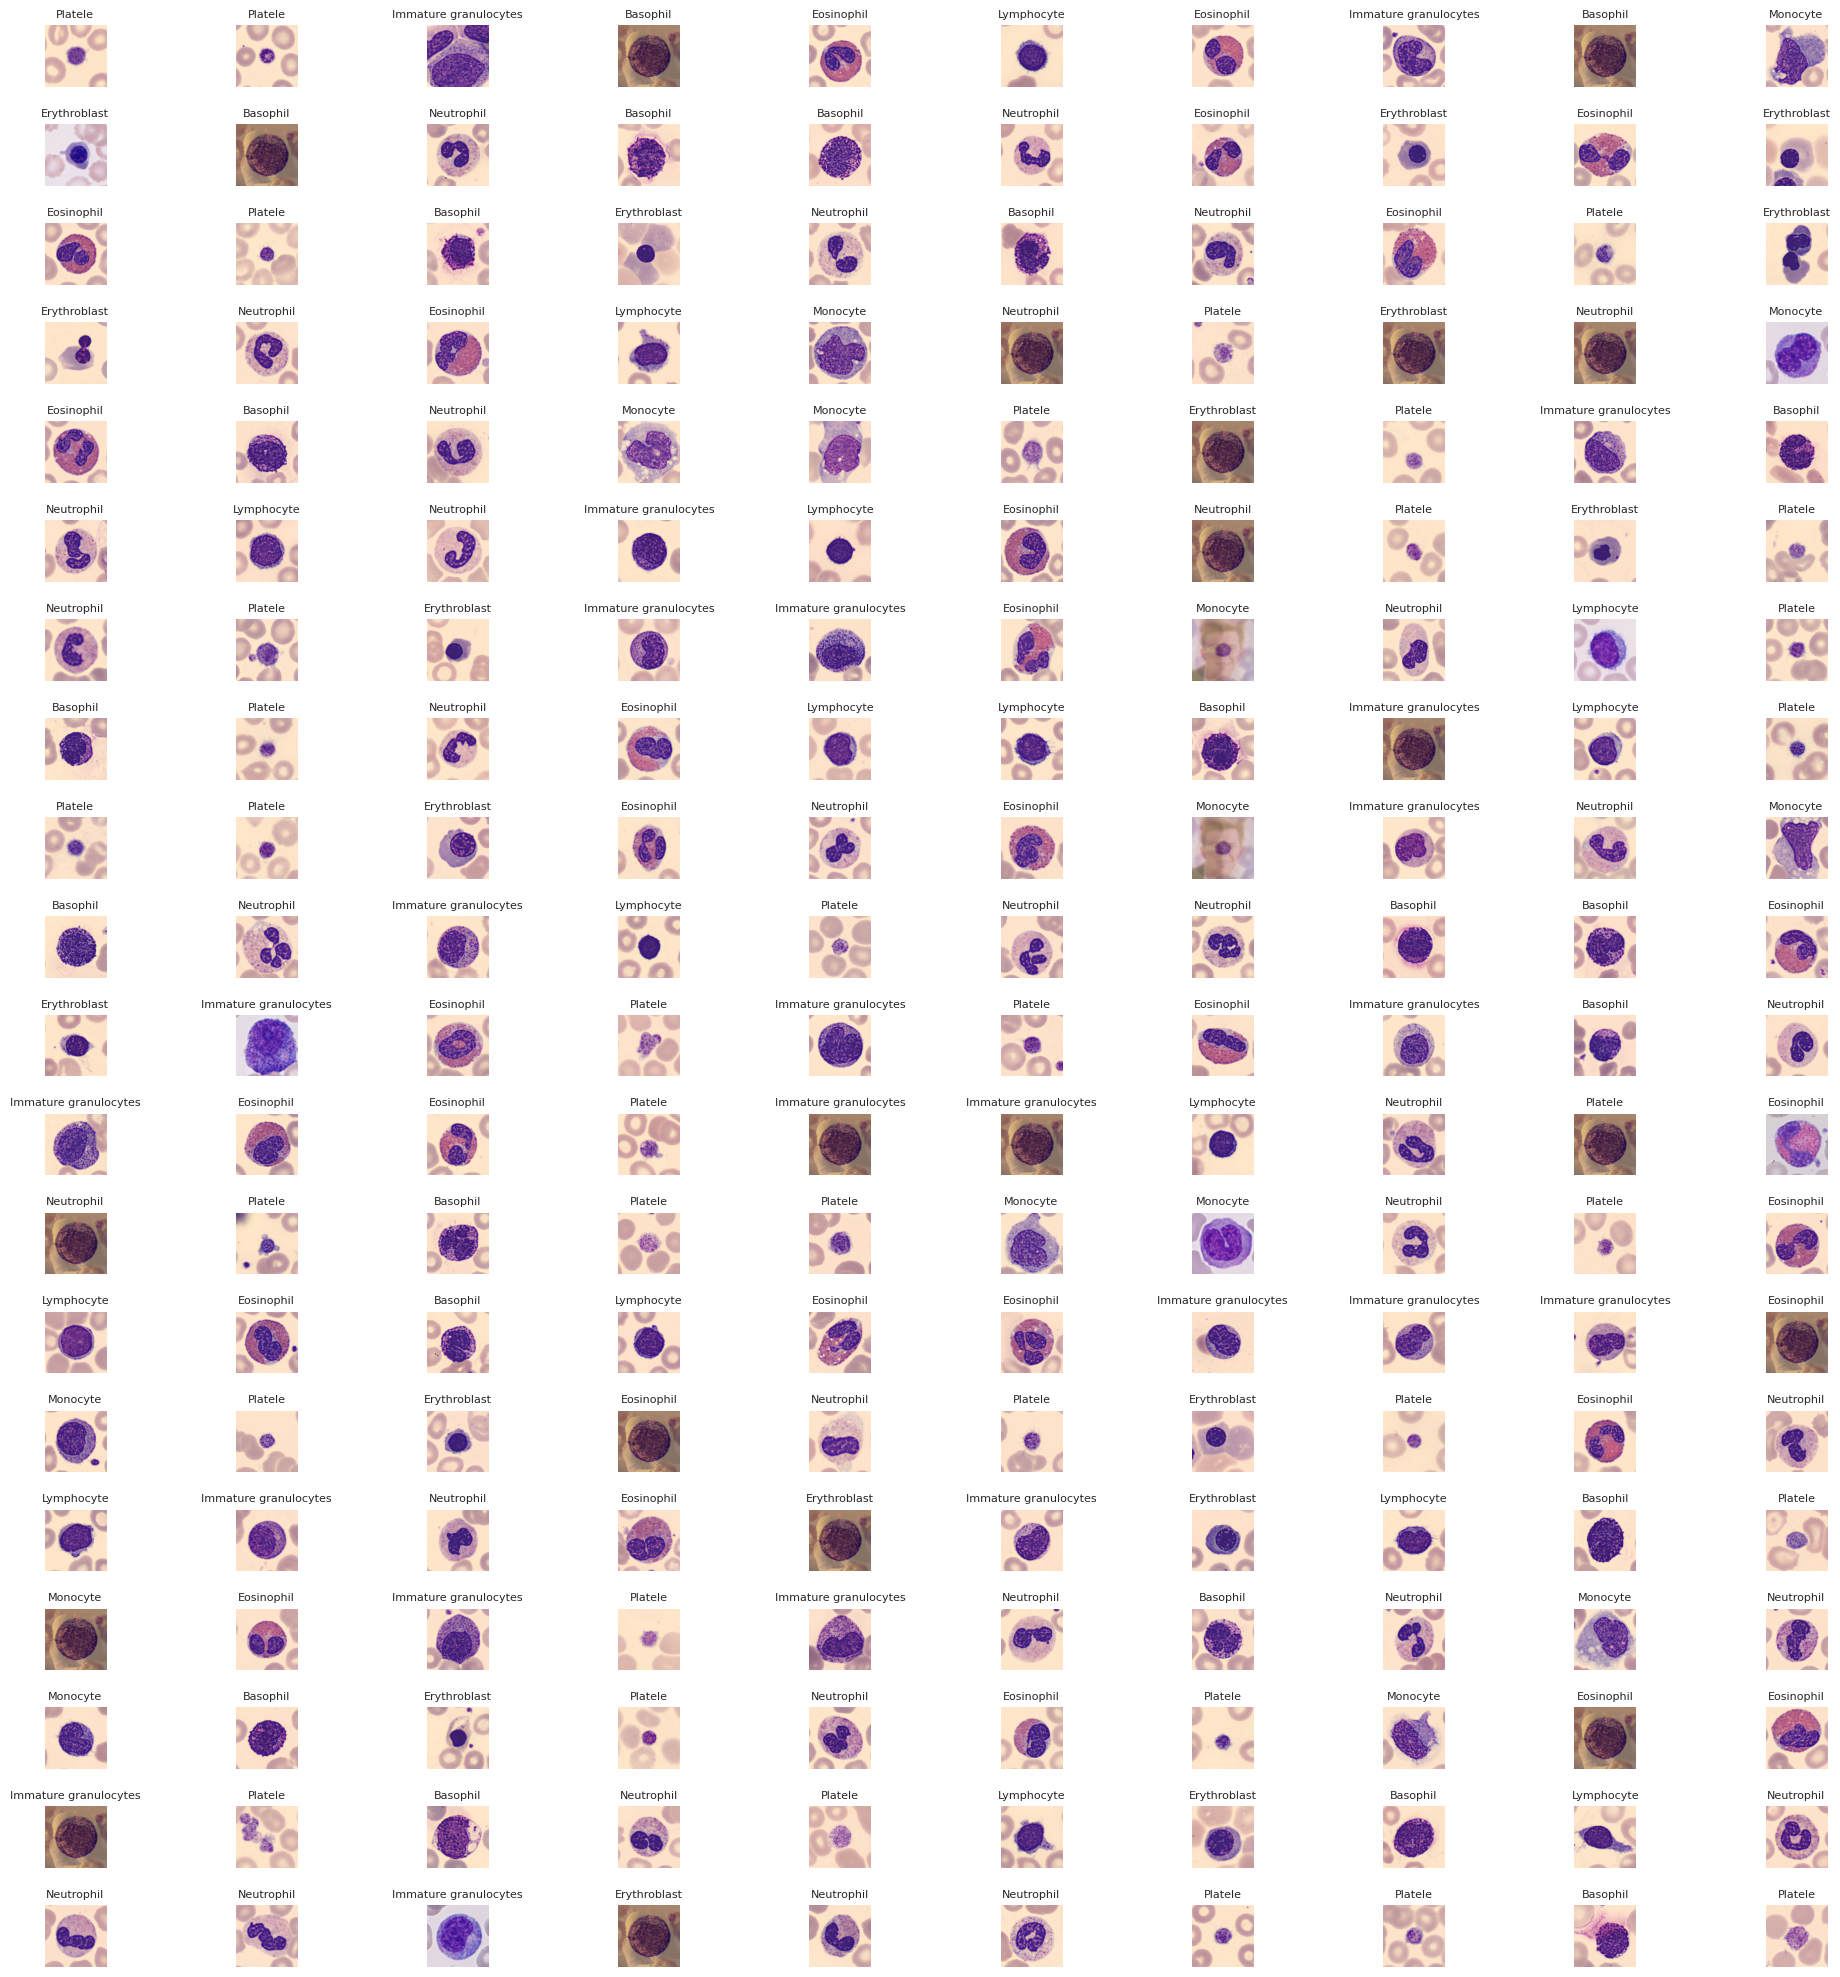

Counting occurrences of target classes:
digit
Neutrophil               2530
Eosinophil               2381
Immature granulocytes    2226
Platele                  1843
Monocyte                 1393
Erythroblast             1285
Basophil                 1052
Lymphocyte               1049
Name: count, dtype: int64


In [10]:
# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)

# Set parameters for visualization
num_images = 200  # Total number of images to display
images_per_row = 10  # Number of images per row
random_indices = random.sample(range(len(X_train_val)), num_images)

# Create a grid of subplots
fig, axes = plt.subplots(
    num_images // images_per_row,
    images_per_row,
    figsize=(20, 20)
)

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(np.squeeze(X_train_val[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{label_names[y_train_val[idx][0]]}', fontsize=8)
    ax.axis('off')

# Hide unused axes if any
for ax in axes[num_images:]:
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train_val, columns=['digit'])['digit'].map(label_names).value_counts())

In [11]:
#filters out junk images in the training-validation set
filter_arr = []
class FoundJunk(Exception): pass
try:
  counter = 0
  while(counter < 30):
    random_indices = random.sample(range(len(X_train_val)), 200)
    for i, idx in enumerate(random_indices):
      for j, jdx in enumerate(random_indices):
        if i != j and np.array_equal(X_train_val[idx], X_train_val[jdx]):
          raise FoundJunk
    counter += 1
except FoundJunk:
  outlier_img = X_train_val[idx]
  for img in X_train_val:
    if np.array_equal(img, outlier_img):
      filter_arr.append(False)
    else:
      filter_arr.append(True)

X_train_val = X_train_val[filter_arr]
y_train_val = y_train_val[filter_arr]

filter_arr = []
class FoundJunk(Exception): pass
try:
  counter = 0
  while(counter < 30):
    random_indices = random.sample(range(len(X_train_val)), 200)
    for i, idx in enumerate(random_indices):
      for j, jdx in enumerate(random_indices):
        if i != j and np.array_equal(X_train_val[idx], X_train_val[jdx]):
          raise FoundJunk
    counter += 1
except FoundJunk:
  outlier_img = X_train_val[idx]
  for img in X_train_val:
    if np.array_equal(img, outlier_img):
      filter_arr.append(False)
    else:
      filter_arr.append(True)

X_train_val = X_train_val[filter_arr]
y_train_val = y_train_val[filter_arr]

Training-Validation Data Shape: (11959, 96, 96, 3)
Training-Validation Label Shape: (11959, 1)


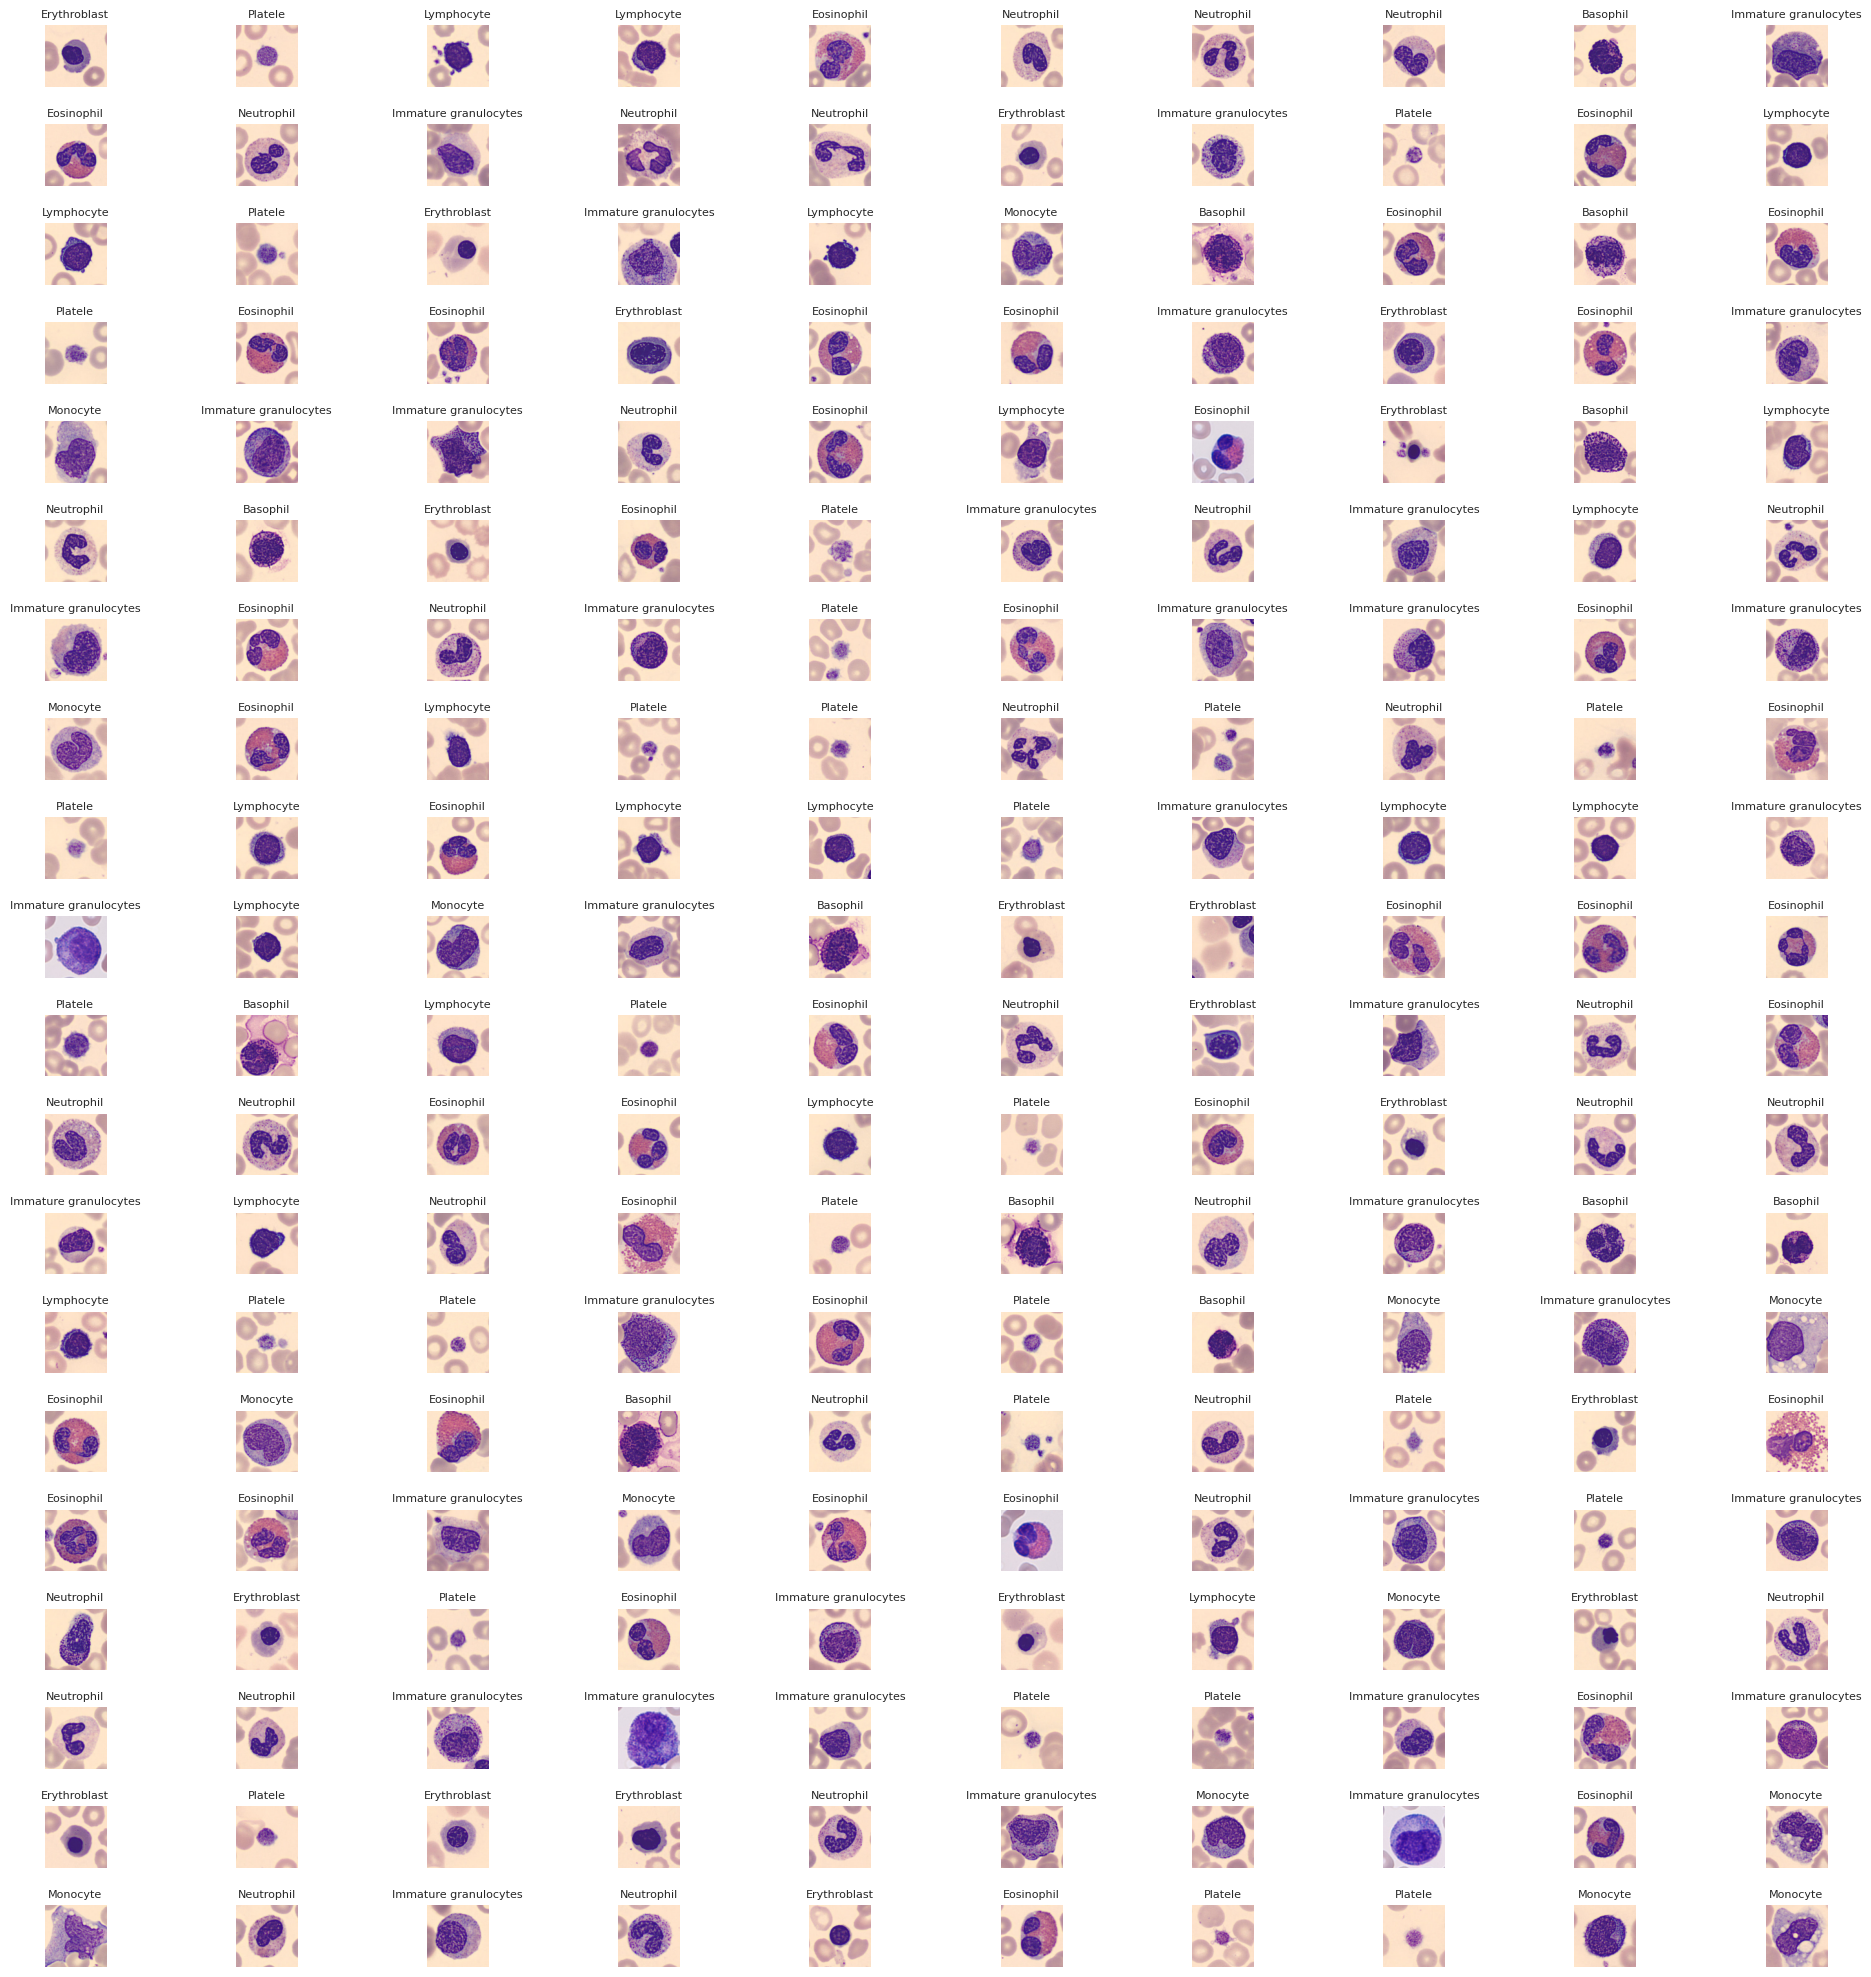

Counting occurrences of target classes:
digit
Neutrophil               2330
Eosinophil               2181
Immature granulocytes    2026
Platele                  1643
Erythroblast             1085
Monocyte                  993
Basophil                  852
Lymphocyte                849
Name: count, dtype: int64


In [12]:
# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)

# Set parameters for visualization
num_images = 200  # Total number of images to display
images_per_row = 10  # Number of images per row
random_indices = random.sample(range(len(X_train_val)), num_images)

# Create a grid of subplots
fig, axes = plt.subplots(
    num_images // images_per_row,
    images_per_row,
    figsize=(20, 20)
)

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(np.squeeze(X_train_val[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{label_names[y_train_val[idx][0]]}', fontsize=8)
    ax.axis('off')

# Hide unused axes if any
for ax in axes[num_images:]:
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train_val, columns=['digit'])['digit'].map(label_names).value_counts())

## 🔄 Save Data

In [13]:
np.savez('clean_dataset.npz', images=X_train_val, labels=y_train_val)

In [14]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('clean_dataset.npz')

/kaggle/working


/kaggle/working/clean_dataset.npz